In [9]:
# ==============================================================================
# Cell 1: Imports & Setup
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import re

# Define Paths
PROCESSED_DATA_PATH = '../data/processed'
OUTPUT_PATH = '../output'
FIGURES_PATH = '../output/figures'

# Ensure output directories exist
os.makedirs(FIGURES_PATH, exist_ok=True)

print("✅ Libraries imported and paths set.")

✅ Libraries imported and paths set.


In [10]:
# ==============================================================================
# Cell 2: Load Data (Merge Phase 2 & Phase 3)
# ==============================================================================
# Load the community map (Artist -> Community ID)
comm_path = os.path.join(PROCESSED_DATA_PATH, 'artist_communities.csv')
df_communities = pd.read_csv(comm_path)

# Load the topic data (Song -> Dominant Topic)
topic_path = os.path.join(PROCESSED_DATA_PATH, 'song_topics.csv')
df_topics = pd.read_csv(topic_path)

print(f"Loaded communities for {len(df_communities)} artists.")
print(f"Loaded topics for {len(df_topics)} songs.")

# Merge them!
# We want to know the Community of the artist who made each song.
df_merged = pd.merge(df_topics, df_communities, left_on='artist', right_on='Artist', how='inner')

print(f"\nMerged Dataset Size: {len(df_merged)} songs")
print(df_merged[['artist', 'title', 'Dominant_Topic', 'Community_ID']].head())

Loaded communities for 180 artists.
Loaded topics for 700 songs.

Merged Dataset Size: 700 songs
    artist           title  Dominant_Topic  Community_ID
0  J. Cole  No Role Modelz               4             0
1  J. Cole       She Knows               4             0
2  J. Cole      Power Trip               2             0
3  J. Cole      Wet Dreamz               4             0
4  J. Cole      Love Yourz               4             0



--- Topic Distribution by Community (Percentage) ---
Dominant_Topic         0         1         2         3         4
Community_ID                                                    
0               0.080000  0.100000  0.130000  0.155000  0.535000
1               0.133333  0.546667  0.073333  0.093333  0.153333
2               0.180000  0.080000  0.460000  0.040000  0.240000
3               0.320000  0.020000  0.060000  0.080000  0.520000
4               0.060000  0.020000  0.140000  0.620000  0.160000
5               0.040000  0.020000  0.640000  0.080000  0.220000
6               0.213333  0.306667  0.080000  0.133333  0.266667

✅ Heatmap saved to: ../output/figures/community_topic_heatmap.png


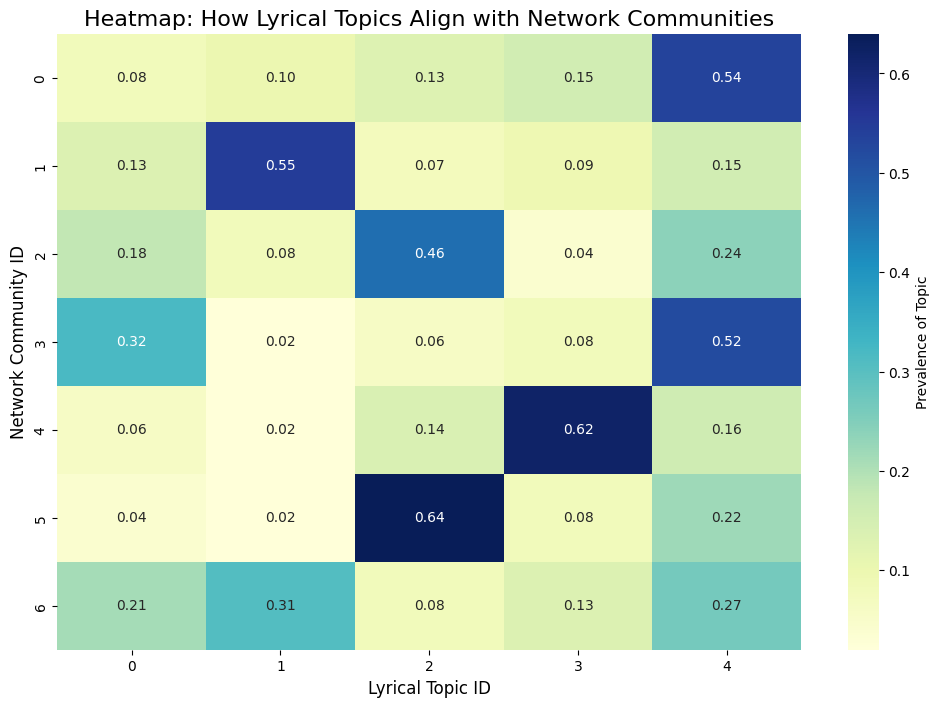

In [11]:
# ==============================================================================
# Cell 3: Analysis - Community vs. Topic (The "Money" Chart)
# ==============================================================================
# We want to see the distribution of topics WITHIN each community.

# Create a crosstab (contingency table)
# Rows = Communities, Columns = Topics, Values = Count of songs
topic_dist = pd.crosstab(df_merged['Community_ID'], df_merged['Dominant_Topic'], normalize='index')

print("\n--- Topic Distribution by Community (Percentage) ---")
print(topic_dist)

# Visualize as a Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(topic_dist, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Prevalence of Topic'})
plt.title('Heatmap: How Lyrical Topics Align with Network Communities', fontsize=16)
plt.ylabel('Network Community ID', fontsize=12)
plt.xlabel('Lyrical Topic ID', fontsize=12)

# Save the heatmap
heatmap_path = os.path.join(FIGURES_PATH, 'community_topic_heatmap.png')
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Heatmap saved to: {heatmap_path}")
plt.show()

In [12]:
# ==============================================================================
# Cell 4: Statistical Validation
# ==============================================================================
# Is this distribution random, or is there a real relationship?
# We can use a Chi-Squared test to find out.

from scipy.stats import chi2_contingency

# Create the raw count table (not normalized) for the test
contingency_table = pd.crosstab(df_merged['Community_ID'], df_merged['Dominant_Topic'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\n--- Chi-Squared Test Results ---")
print(f"Chi2 Statistic: {chi2:.4f}")
print(f"P-Value: {p:.4e}") # Scientific notation

if p < 0.05:
    print("✅ RESULT: Statistically Significant (p < 0.05)")
    print("   There IS a strong relationship between an artist's social community and their lyrical content.")
else:
    print("❌ RESULT: Not Statistically Significant (p >= 0.05)")
    print("   We could not prove a strong link between community and topic.")


--- Chi-Squared Test Results ---
Chi2 Statistic: 405.2219
P-Value: 6.3596e-71
✅ RESULT: Statistically Significant (p < 0.05)
   There IS a strong relationship between an artist's social community and their lyrical content.


In [13]:
# ==============================================================================
# Cell 5: Interpretation Helper
# ==============================================================================
# Let's print the top words for each topic again to help you label the heatmap.
# You'll need to load the LDA model first (or just copy-paste from Phase 3 output).

import gensim
model_path = os.path.join('../output/models', 'lda_model')

try:
    lda_model = gensim.models.LdaMulticore.load(model_path)
    print("\n--- Topic Reference Guide ---")
    for idx, topic in lda_model.print_topics(-1):
        # Clean up the string for easier reading
        clean_topic = re.sub(r'0\.\d+\*', '', topic).replace(' + ', ', ').replace('"', '')
        print(f"Topic {idx}: {clean_topic}")
except Exception as e:
    print(f"Could not load model for reference (not critical): {e}")
    print("Refer to your Phase 3 notebook output for topic keywords.")


--- Topic Reference Guide ---
Topic 0: ooh, versace, feel, young, need, dope, bad, light, gon, keep
Topic 1: way, woo, money, ayy, woah, lil, hey, gon, gotta, baby
Topic 2: think, fuckin, tell, hope, fucking, youre, gon, come, look, give
Topic 3: life, right, feel, walk, god, real, talk, man, gang, night
Topic 4: girl, wanna, baby, youre, right, tell, need, ill, way, even



Generating Community DNA charts...
✅ Radar charts saved to: ../output/figures/community_radar_charts.png


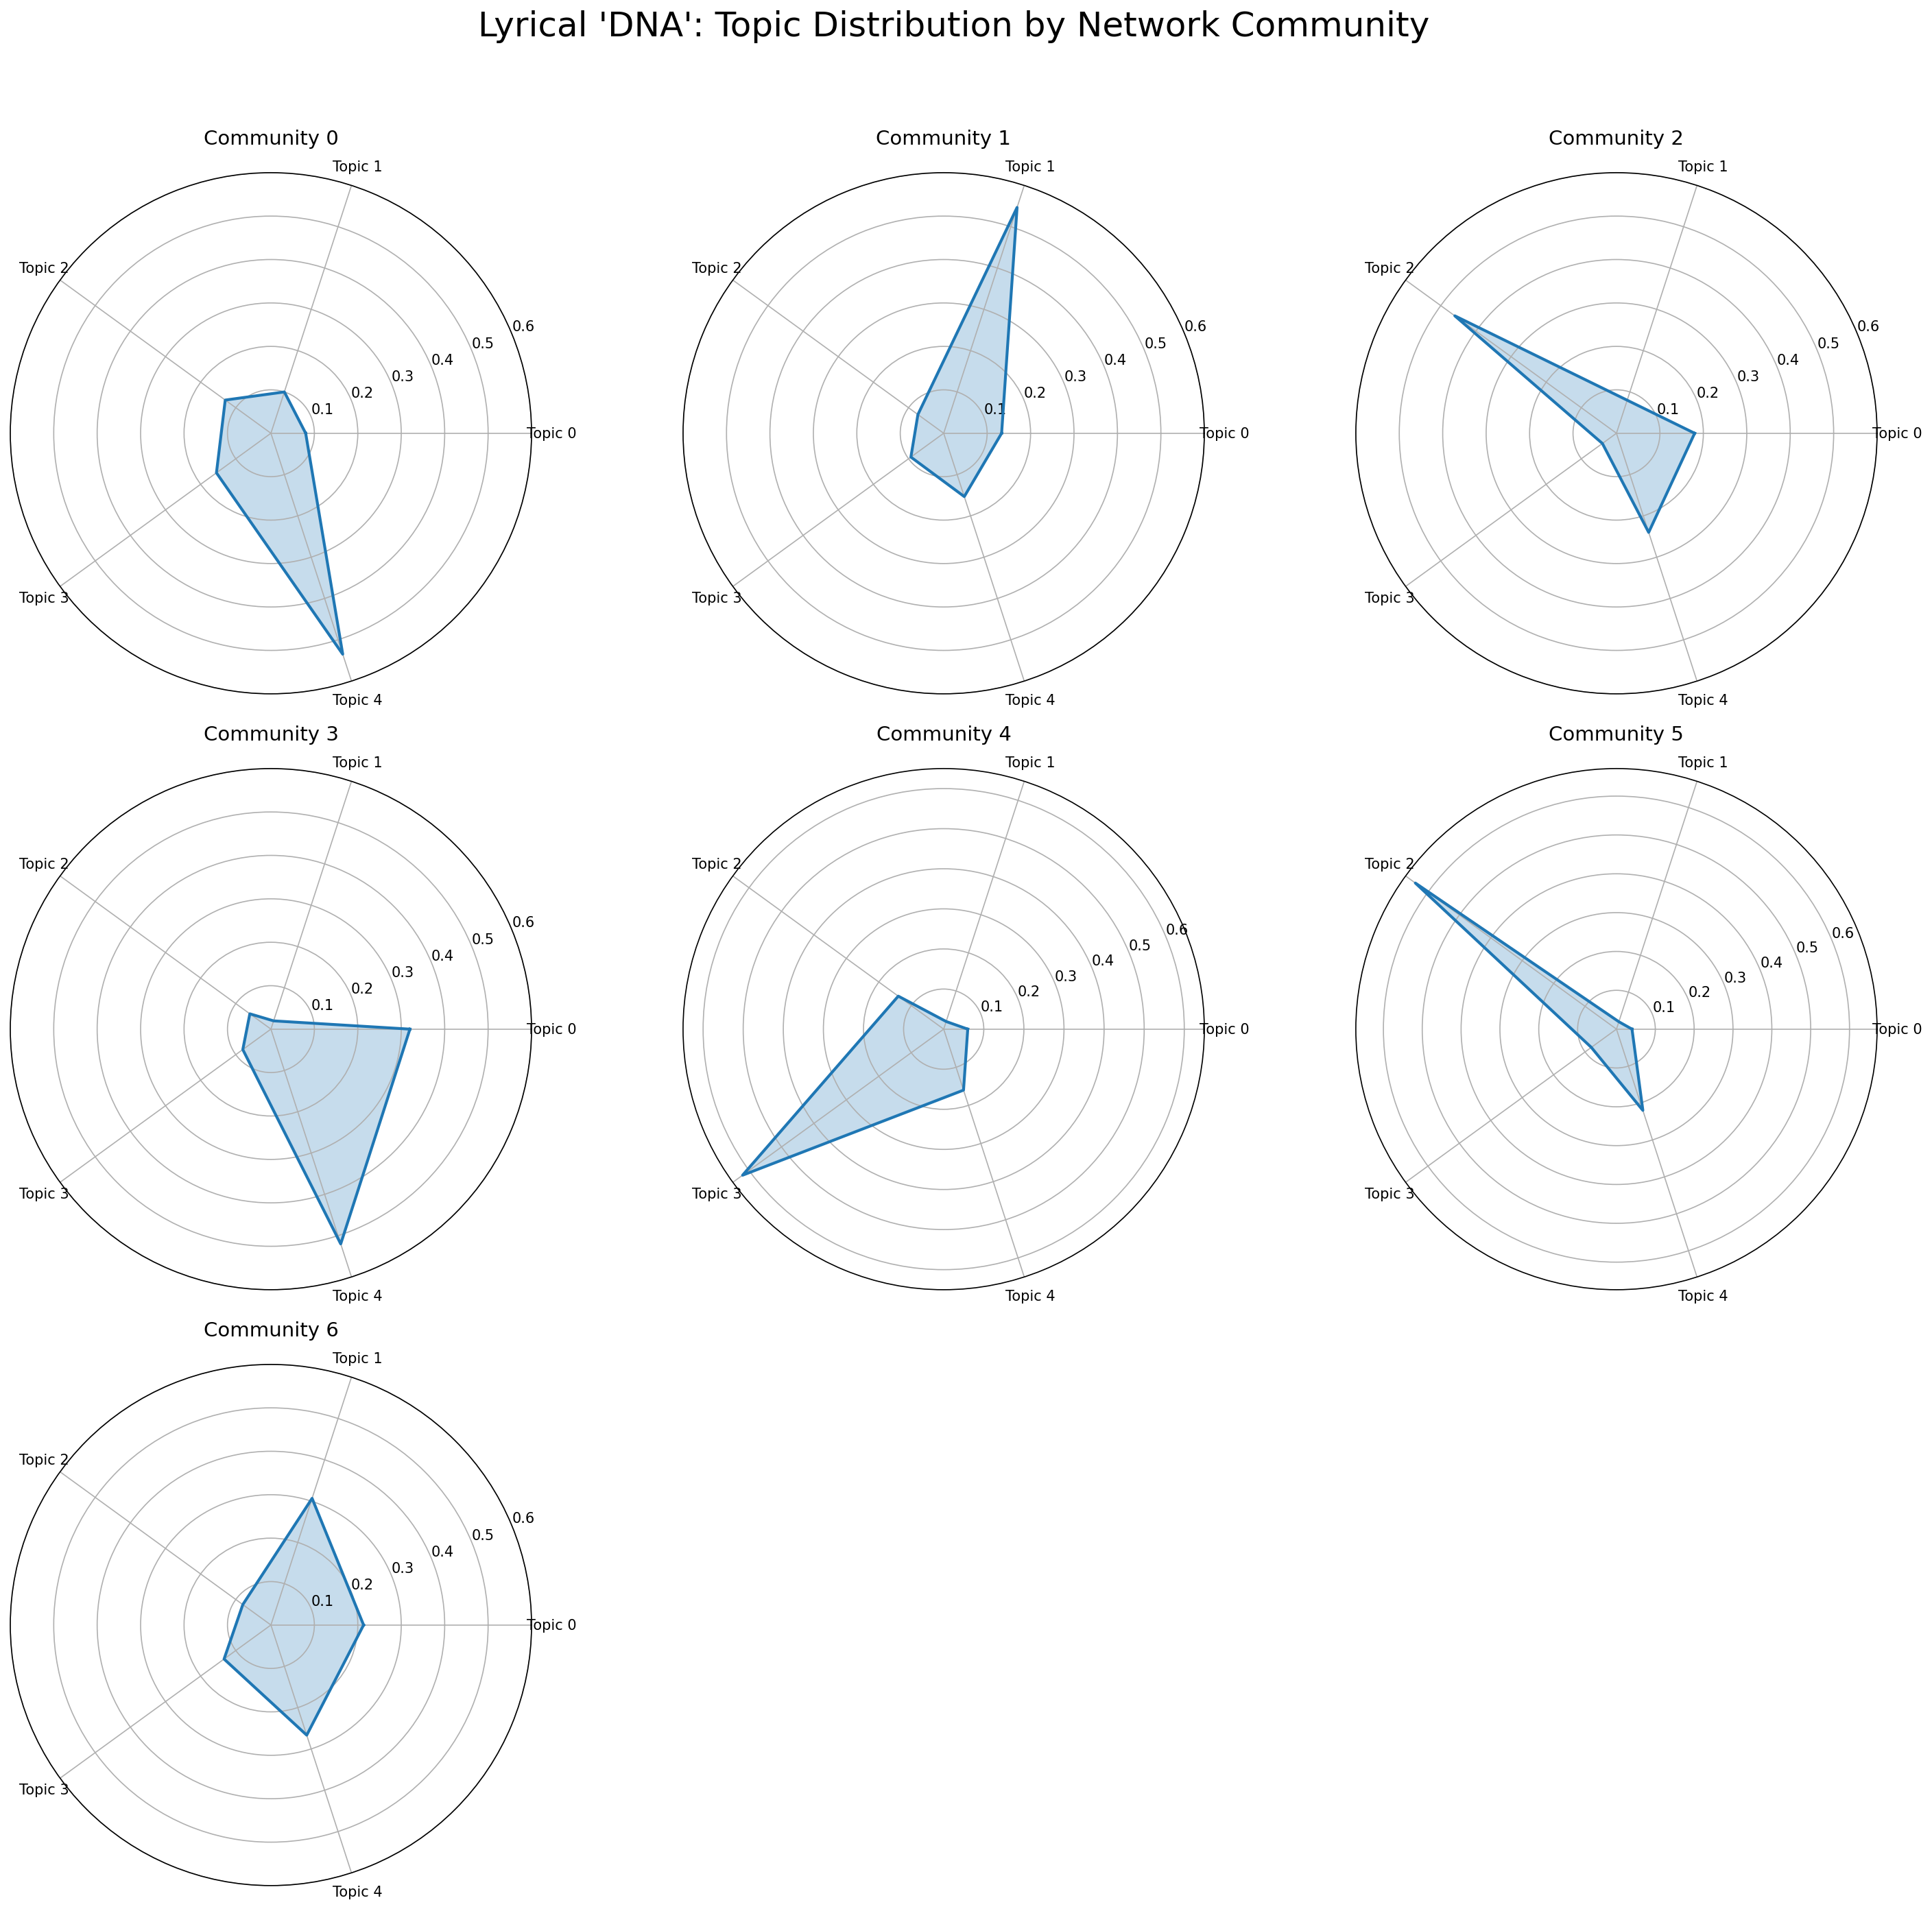

In [15]:
# ==============================================================================
# Cell 6: Visualization - Community "DNA" Radar Charts (FIXED)
# ==============================================================================
# A radar chart is the best way to visualize a "fingerprint" of each community's lyrical mix.

# Get the Community-Topic distribution table (from Cell 3)
topic_dist = pd.crosstab(df_merged['Community_ID'], df_merged['Dominant_Topic'], normalize='index')

# We don't have a 'Leader' column, so we'll map the Community ID to the seed artist name
# for better labeling, but title the charts with the Community ID itself for safety.

# Get the topic labels (e.g., "Topic 0", "Topic 1"...)
labels = [f"Topic {i}" for i in topic_dist.columns]
num_vars = len(labels)

# Set up the angles for the radar chart (one for each topic)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] # Close the circle

# Determine the number of rows needed for the subplot grid (7 communities)
max_communities = topic_dist.index.max() + 1
# We use a 3x3 or 4x2 grid to hold 7 communities
ncols = 3 
nrows = int(np.ceil(max_communities / ncols))

# Create the figure
fig, axes = plt.subplots(figsize=(20, 18), dpi=150,
                         subplot_kw=dict(polar=True),
                         nrows=nrows, ncols=ncols)
axes = axes.flatten()

print("\nGenerating Community DNA charts...")

# Loop through each community and draw its radar chart
for i, community_id in enumerate(topic_dist.index):
    row = topic_dist.loc[community_id]
    ax = axes[i]
    
    # Get the stats and "close the loop"
    stats = row.values.tolist()
    stats += stats[:1]
    
    # Draw the plot
    ax.plot(angles, stats, linewidth=2, linestyle='solid')
    ax.fill(angles, stats, alpha=0.25)
    
    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) # y-axis ticks
    
    # Title using the Community ID (e.g., "Community 0")
    # You can manually replace this title later with the "Key Artist"
    ax.set_title(f"Community {community_id}", 
                 size=14, pad=20)

# Hide unused subplots
for j in range(len(topic_dist.index), len(axes)):
    axes[j].axis('off')

fig.suptitle("Lyrical 'DNA': Topic Distribution by Network Community", fontsize=24, y=1.03)
plt.tight_layout()

# Save
fig_path = os.path.join(FIGURES_PATH, 'community_radar_charts.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Radar charts saved to: {fig_path}")
plt.show()